## Word Embedding Model

In [257]:
!pip install nltk
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
import re, nltk, numpy, matplotlib
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from datetime import datetime
import string
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [248]:
data = pd.read_csv("US_Debates_ngrams.csv")
data.head()
df = data.drop(columns=['Title', 'State', 'Volume', 'Where', 'Unnamed: 9', 'Unnamed: 11', 'Order']) # Remove columns
df. dropna() # Drop NA rows
len(df)

742

In [241]:
# Finding total number of words
text =df['text'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

468684

In [249]:
stop_words_file = 'english.stop.txt' # Stopword list

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = raw_text.replace("supreme court", "supreme_court")
    letters_only_text = letters_only_text.replace("madam speaker", "madam_speaker")
    letters_only_text = letters_only_text.replace("mr speaker", "mr_speaker")
    letters_only_text = letters_only_text.replace("african american", "african_american")
    letters_only_text = letters_only_text.replace("north carolina", "north_carolina")
    letters_only_text = letters_only_text.replace("united state", "united_states")
    letters_only_text = letters_only_text.replace("u.s.", "united_states")
    letters_only_text = letters_only_text.replace(',',"")

     # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # lemmatise words
    lemmatised_words = []
    for word in cleaned_words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word)  
        lemmatised_words.append(word)

    # converting list back to string
    return " ".join(lemmatised_words)

In [243]:
test_sentence = "this is a sentence, to demonstrate u.s. how the function works...!"

preprocess(test_sentence)

'sentence demonstrate united_states function works...!'

In [250]:
df['text']=df['text'].apply(str) # Converting text column into string so that preprocessing works

df['we'] = df['text'].apply(preprocess)
df.head()

,Date,Speaker,Party,text,Congress,we
0,"Thursday, January 3, 2013",Ms. SLAUGHTER,Democratic,Under the cover of a cynical and untruthful cl...,113th,cover cynical untruthful claim voter fraud thr...
1,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,"As a Member of this body, I firmly believe th...",113th,member body firmly protect right eligible citi...
2,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,There have been several restrictive voting bi...,113th,restrictive voting bill considered approved st...
3,"Thursday, February 14, 2014",Mr. VEASEY,Democratic,As oral arguments are being prepared for the F...,113th,oral argument prepared february 27 u.s. suprem...
4,"Monday, February 25, 2013",Mr. JEFFRIES,Democratic,Perhaps the most relevant example of why secti...,113th,relevant section 5 continues relevant due plac...


In [251]:
joined = " ".join(df['we'])
all_id = re.findall("identification",joined)
len(all_id)

1084

In [252]:
# sub corpus of democratic speeches
is_dem =  df['Party']=='Democratic'
dem = df[is_dem]
len(dem)

473

In [334]:
# sub corpus of republican speeches
is_rep =  df['Party']=='Republican'
rep = df[is_rep]
len(rep)

269

In [332]:
# Filtering words that appear less than 3 times overall, by (1) Splitting sentences into words, (2) Computing global word frequency, (3) Filtering words based on computed frequencies, (4) Joining and re-assigning
from collections import Counter
from itertools import chain

# split words into lists
v = dem['we'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
dem['we'] = [' '.join([j for j in i if c[j] > 3]) for i in v]


C:\Users\analo\AppData\Local\Temp/ipykernel_25572/601573790.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dem['we'] = [' '.join([j for j in i if c[j] > 3]) for i in v]


In [335]:
v = rep['we'].str.split().tolist() 
c = Counter(chain.from_iterable(v))
rep['we'] = [' '.join([j for j in i if c[j] > 3]) for i in v]

C:\Users\analo\AppData\Local\Temp/ipykernel_25572/435848129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep['we'] = [' '.join([j for j in i if c[j] > 3]) for i in v]


In [336]:
# DEMOCRATIC SPEECHES
trans_d = str.maketrans('', '', string.punctuation) # translation scheme for removing punctuation
uniquesentences_d = set()
for statement_d in tqdm(dem['we']):
    for sentence in nltk.tokenize.sent_tokenize(statement_d):
        # remove HTML tags in there
        sentence_d = re.sub(r"<.*?>"," ",sentence)
        sentence_d = sentence.translate(trans_d) 
        if sentence not in uniquesentences_d:
            uniquesentences_d.add(sentence.lower())

100%|██████████| 473/473 [00:00<00:00, 582.62it/s]


In [337]:
# REPUBLICAN SPEECHES
trans_r = str.maketrans('', '', string.punctuation) # translation scheme for removing punctuation
uniquesentences_r = set()
for statement_r in tqdm(rep['we']):
    for sentence in nltk.tokenize.sent_tokenize(statement_r):
        # remove HTML tags in there
        sentence_r = re.sub(r"<.*?>"," ",sentence)
        sentence_r = sentence.translate(trans_r) 
        if sentence not in uniquesentences_r:
            uniquesentences_r.add(sentence.lower())

100%|██████████| 269/269 [00:00<00:00, 941.28it/s] 


In [338]:
print(f"We now have {len(uniquesentences_d)} and {len(uniquesentences_r)} unique democratic and republican sentences respectively.")


We now have 8167 and 5246 unique democratic and republican sentences respectively.


## Step 3: Train the model
Using gensim

In [349]:
# We define the number of words we want to keep (in this case 6000) and fit the vectorizer using the full corpus of text data. 
from sklearn.feature_extraction.text import TfidfVectorizer
demcorp = list(dem['we'])
tfidf = TfidfVectorizer(max_features = 6000) 
tfidf.fit(demcorp)
tfidf_features = tfidf.transform(demcorp)
print(tfidf_features.shape)

(473, 3437)


In [339]:
tokenizedsentences_d = (sentence.split() for sentence in uniquesentences_d)
tokenizedsentences2_d = (sentence.split() for sentence in uniquesentences_d)

tokenizedsentences_r = (sentence.split() for sentence in uniquesentences_r)
tokenizedsentences2_r = (sentence.split() for sentence in uniquesentences_r)

In [340]:
## Generating REPUBLICAN we model
print(f"Started setting up the model at {datetime.now()}")
model_r = gensim.models.Word2Vec(vector_size=300) # we want 300 dimensions
model_r.build_vocab(tokenizedsentences_r)
print(f"Started training at {datetime.now()}")
model_r.train(tokenizedsentences2_r, total_examples=model_r.corpus_count,  epochs=1)
print(f"Finished training at {datetime.now()}")

2021-11-15 12:56:43,936 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-11-15T12:56:43.934008', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'created'}
2021-11-15 12:56:43,938 : INFO : collecting all words and their counts
2021-11-15 12:56:43,939 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-15 12:56:43,962 : INFO : collected 2698 word types from a corpus of 54984 raw words and 5246 sentences
2021-11-15 12:56:43,964 : INFO : Creating a fresh vocabulary
2021-11-15 12:56:43,970 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2202 unique words (81.61601186063751%% of original 2698, drops 496)', 'datetime': '2021-11-15T12:56:43.970929', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'pla

Started setting up the model at 2021-11-15 12:56:43.923923
Started training at 2021-11-15 12:56:44.018413


2021-11-15 12:56:44,131 : INFO : EPOCH - 1 : training on 54984 raw words (46385 effective words) took 0.1s, 488860 effective words/s
2021-11-15 12:56:44,132 : INFO : Word2Vec lifecycle event {'msg': 'training on 54984 raw words (46385 effective words) took 0.1s, 408686 effective words/s', 'datetime': '2021-11-15T12:56:44.132960', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'train'}


Finished training at 2021-11-15 12:56:44.134960


In [341]:
## Generating DEMOCRATIC we model
print(f"Started setting up the model at {datetime.now()}")
model_d = gensim.models.Word2Vec(vector_size=300) # we want 300 dimensions
model_d.build_vocab(tokenizedsentences_d)
print(f"Started training at {datetime.now()}")
model_d.train(tokenizedsentences2_d, total_examples=model_d.corpus_count,  epochs=1)
print(f"Finished training at {datetime.now()}")

2021-11-15 12:56:46,949 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-11-15T12:56:46.949451', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'created'}
2021-11-15 12:56:46,961 : INFO : collecting all words and their counts
2021-11-15 12:56:46,963 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-15 12:56:46,989 : INFO : collected 3991 word types from a corpus of 100229 raw words and 8167 sentences
2021-11-15 12:56:46,989 : INFO : Creating a fresh vocabulary
2021-11-15 12:56:47,005 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 3209 unique words (80.4059133049361%% of original 3991, drops 782)', 'datetime': '2021-11-15T12:56:47.005391', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'pla

Started setting up the model at 2021-11-15 12:56:46.949451
Started training at 2021-11-15 12:56:47.121649


2021-11-15 12:56:48,875 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-15 12:56:48,879 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-15 12:56:48,960 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-15 12:56:48,961 : INFO : EPOCH - 1 : training on 100229 raw words (87405 effective words) took 0.4s, 200885 effective words/s
2021-11-15 12:56:48,962 : INFO : Word2Vec lifecycle event {'msg': 'training on 100229 raw words (87405 effective words) took 1.8s, 47497 effective words/s', 'datetime': '2021-11-15T12:56:48.962733', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'train'}


Finished training at 2021-11-15 12:56:48.964727


In [342]:
# Republican id similarity
import gensim
similar_to_id_r = model_r.wv.most_similar("identification",topn=30)
id_similar_r = pd.DataFrame(similar_to_id_r)
id_similar_r.columns=['word', 'similarity']
id_similar_r 


,word,similarity
0,election,0.880679
1,voter,0.880289
2,state,0.868008
3,bill,0.863053
4,vote,0.861300
5,voting,0.859064
6,federal,0.853488
7,time,0.851797
8,american,0.844491
9,senator,0.843534


In [343]:
# Democratic id similarity
import gensim
similar_to_id_d = model_d.wv.most_similar("identification",topn=30)
id_similar_d = pd.DataFrame(similar_to_id_d)
id_similar_d.columns=['word', 'similarity']
id_similar_d 


,word,similarity
0,state,0.996011
1,law,0.995890
2,voting,0.995639
3,voter,0.995545
4,election,0.995499
5,vote,0.995350
6,democracy,0.995063
7,vra,0.994800
8,american,0.994781
9,republican,0.994779


In [344]:
# Plotting words in a scatter plot
import pandas as pd
import matplotlib.pyplot as plt
def similarity(df, x_dim, y_dim):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(10, 10))
  #customizes alpha for each dot in the scatter plot
  ax.scatter(x, y, alpha=0.70, color='red')
 
  #adds a title and axes labels
  ax.set_title('Word Frequencies')
  ax.set_xlabel('Frequency')
  ax.set_ylabel('Word')
 
  #removing top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  #adds major gridlines
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
  plt.show()


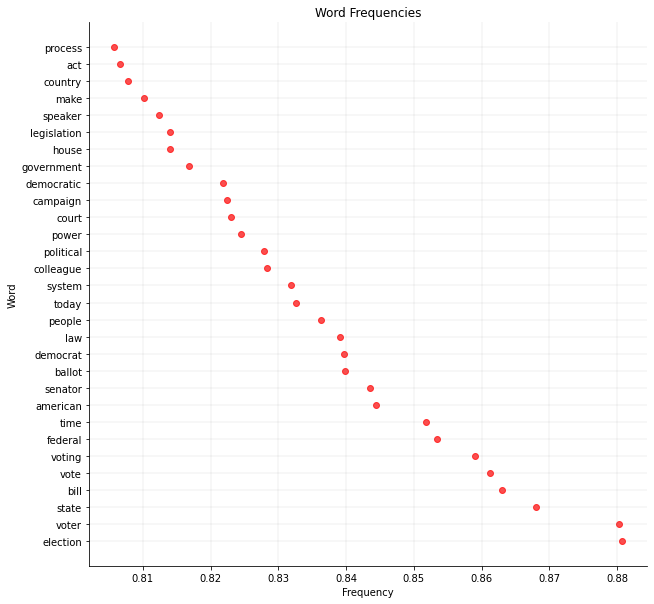

In [345]:
similarity(id_similar_r, 'similarity', 'word')

In [ ]:
gensim.models.Word2Vec?

In [161]:
model_r.save("mymodel_r")

2021-11-12 11:07:09,969 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'mymodel_r', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-12T11:07:09.969520', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'saving'}
2021-11-12 11:07:09,974 : INFO : not storing attribute cum_table
2021-11-12 11:07:09,988 : INFO : saved mymodel_r


In [162]:
# and load it again, just to check
mymodel_r = gensim.models.Word2Vec.load("mymodel_r")

2021-11-12 11:07:15,198 : INFO : loading Word2Vec object from mymodel_r
2021-11-12 11:07:15,220 : INFO : loading wv recursively from mymodel_r.wv.* with mmap=None
2021-11-12 11:07:15,222 : INFO : setting ignored attribute cum_table to None
2021-11-12 11:07:15,301 : INFO : Word2Vec lifecycle event {'fname': 'mymodel_r', 'datetime': '2021-11-12T11:07:15.301153', 'gensim': '4.1.2', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'loaded'}


In [163]:
model_r

Visualising word2vec embedding models

In [277]:
import multiprocessing

In [291]:
# Selecting keyword from the Republican vocabulary of the pre-trained model and preparing word vectors for visualization.
keys = ['identification']

embedding_clusters_r = []
word_clusters_r = []
for word in keys:
    embeddings_r = []
    words_r = []
    for similar_word, _ in model_r.wv.most_similar(word, topn=60):
        words_r.append(similar_word)
        embeddings_r.append(model_r.wv[similar_word])
    embedding_clusters_r.append(embeddings_r)
    word_clusters_r.append(words_r)

In [292]:
# Democrat vocab
keys = ['identification']
embedding_clusters_d = []
word_clusters_d = []
for word in keys:
    embeddings_d = []
    words_d = []
    for similar_word, _ in model_d.wv.most_similar(word, topn=60):
        words_d.append(similar_word)
        embeddings_d.append(model_d.wv[similar_word])
    embedding_clusters_d.append(embeddings_d)
    word_clusters_d.append(words_d)

In [313]:
#REP
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters_r = np.array(embedding_clusters_r)
n, m, k = embedding_clusters_r.shape
tsne_model_en_2d_r = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, random_state=32)
embeddings_en_2d_r = np.array(tsne_model_en_2d_r.fit_transform(embedding_clusters_r.reshape(n * m, k))).reshape(n, m, 2)


C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [295]:
#DEM
embedding_clusters_d = np.array(embedding_clusters_d)
n, m, k = embedding_clusters_d.shape
tsne_model_en_2d_d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d_d = np.array(tsne_model_en_2d_d.fit_transform(embedding_clusters_d.reshape(n * m, k))).reshape(n, m, 2)

C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [314]:
# creating a 2D scatter plot using Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c='#808080', alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

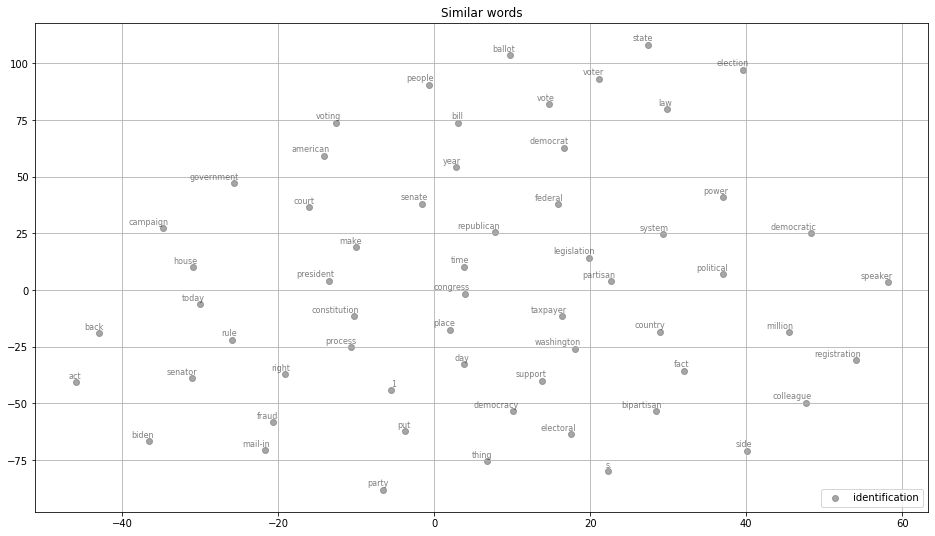

In [315]:
#REPUBLICAN
tsne_plot_similar_words('Similar words', keys, embeddings_en_2d_r, word_clusters_r, 0.7,
                        'similar_words.png')

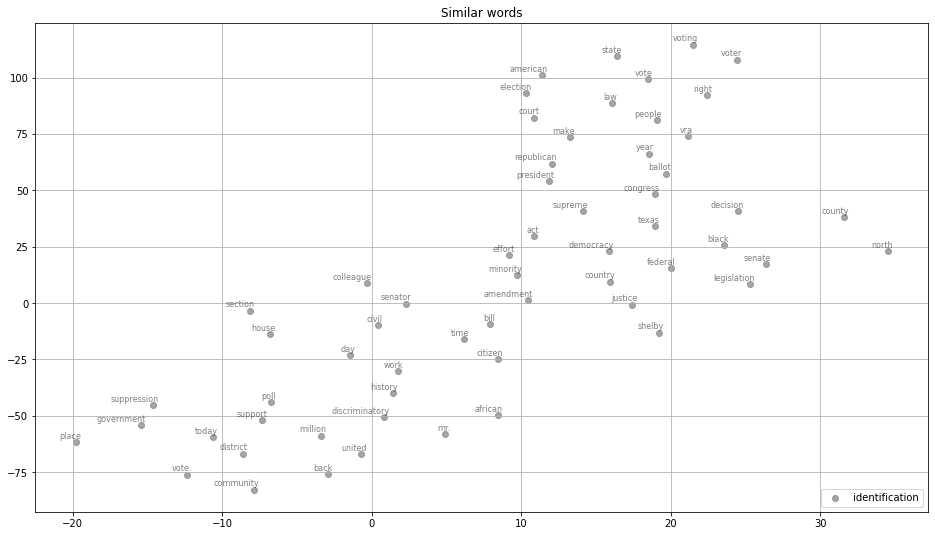

In [304]:
#DEMOCRATIC
tsne_plot_similar_words('Similar words', keys, embeddings_en_2d_d, word_clusters_d, 0.7,
                        'similar_words.png')

In [267]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [166]:
# Test the loaded word2vec model in gensim
# We will need the raw vector for a word
print(model_r.wv['identification']) 

# We will also need to get the words closest to a word
model_r.wv.similar_by_word('identification')

[ 1.78562521e-04  2.56949943e-03  1.65691126e-05  2.98317149e-03
 -2.65994039e-03 -1.75173115e-03  1.34768046e-03  1.05379394e-03
 -6.04884292e-04  3.16496496e-03 -1.23850920e-03 -3.00508458e-03
  3.18610552e-03 -2.40210188e-03 -6.76808006e-04 -7.82882707e-05
  2.59105535e-03 -4.64044249e-04 -2.31222063e-03  3.56648932e-04
 -1.93625444e-03  1.10296882e-03  1.69223733e-03  2.84104631e-03
  1.50971406e-03  2.47873086e-03 -1.95383164e-03 -2.00679619e-03
 -4.01387108e-04 -3.58720194e-03 -8.39220302e-04 -5.04601921e-04
 -1.19492272e-03  2.32011452e-03 -3.22388508e-03 -5.64101385e-04
 -2.12168973e-03 -2.53773149e-04 -7.86826015e-04  1.81536202e-03
  1.03334174e-03  1.40826101e-03 -2.78496905e-03 -3.29489633e-03
  3.11862654e-03  1.20431464e-03  2.86046090e-03  3.38762882e-03
 -1.71410595e-03  3.98536166e-03  3.16034234e-03  3.81235586e-04
 -3.39729455e-03 -1.88648060e-03 -4.62747033e-04 -1.20783702e-03
 -2.46994849e-03 -1.09389145e-03 -2.81638023e-03 -2.85674469e-03
  2.00769445e-03  1.65805

[('id', 0.2973322570323944),
 ('ballot', 0.2947756350040436),
 ('election', 0.2842372953891754),
 ('voting', 0.27595555782318115),
 ('democratic', 0.2626058757305145),
 ('bill', 0.2593684196472168),
 ('taxpayer', 0.259235143661499),
 ('mail', 0.2567828297615051),
 ('american', 0.2563724219799042),
 ('state', 0.2562198042869568)]

Trying something else from: https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim

In [271]:
vocab_r = list(model_r.wv.key_to_index)
X_r = model_r.wv[vocab_r]

In [273]:
tsne_r = TSNE(n_components=2)
X_tsne_r = tsne_r.fit_transform(X_r)

C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [274]:
df_r = pd.DataFrame(X_tsne_r, index=vocab_r, columns=['x', 'y'])
df_r.head()

,x,y
election,61.236691,9.136058
state,61.059994,9.055294
voter,60.436230,9.155704
bill,59.623249,9.094168
democrat,59.052185,10.025415


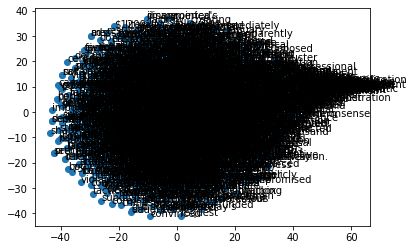

In [275]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_r['x'], df_r['y'])
for word, pos in df_r.iterrows():
    ax.annotate(word, pos)


Trying another way from https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

Plotting the whole model

C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


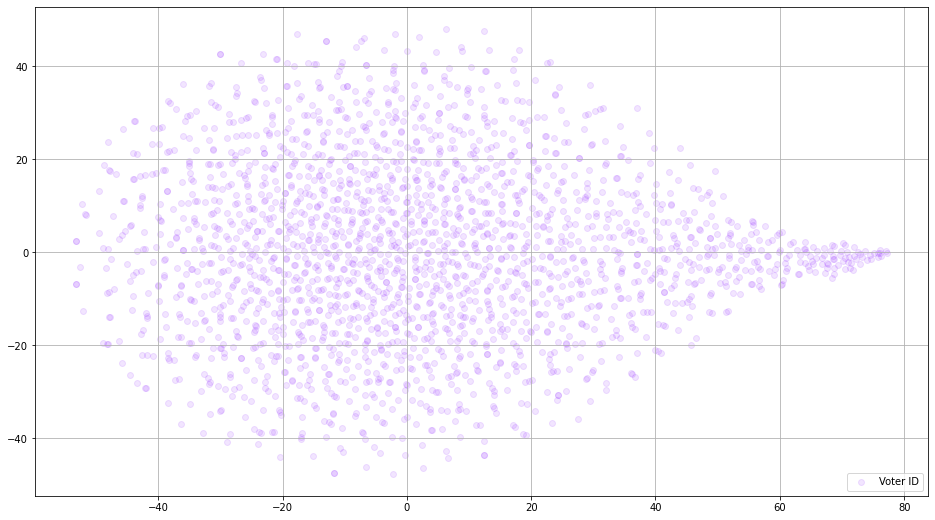

In [281]:
words_ak = []
embeddings_ak = []
for word in list(model_r.wv.key_to_index):
    embeddings_ak.append(model_r.wv[word])
    words_ak.append(word)
    
tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Voter ID', embeddings_ak_2d, a=0.1)
